# COS 3a Exercise 8

---
Submission until 10/12/2024 12:00 p.m.


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.constants as sc

## Tutorial

### (Electronic) Circular Dichroism (ECD)

ECD spectroscopy can be used to distinguish between two enantiomeres. Since the enenatiomers show spectra with opposite signs.  
However, without separation of both enantiomers and a subsequent recording of separate spectra, it is not easily possible to determine which absolute configuration is present.  
Therefore, simulation of such spectra by means of quantum-chemical methods can bes used to determine which enantiomer has been measured.  
The computational workflow to determine such spectra has been partially covered before and we will shortly glance over it again.  

### Multilevel Workflow for Spectra Simulation

First, we start with a conformer analysis, using tools such as CREST and efficient electronic structure methods such as GFN2-xTB and potentially implicit solvation models.  
The conformer ensemble is then repotimized using a low-cost DFT method to sort out duplicates and further reduce the energy interval for the ensemble.  
At this point, our geometries are fixed and we will further refine the level of theory for the Boltzmann weights and compute our property.

<img src="../images/exercise_8/multilevel.png" alt="multilevel workflow" width="30%">


### Simulation of ECD spectra

The first step to simulate ECD spectra is to choose a level of theory to describe the excited states.
The workhorse for most electronic structure calculations in the ground state is density functional theory (DFT), since it shows a good balance between accuracy and computational effort.  
DFT has been extended to compute time dependant properties, establishing TD-DFT and resulting in the non-hermitian equations shown below.

$\begin{pmatrix}
    \mathbf{A} & \mathbf{B} \\
    \mathbf{B^*} & \mathbf{A^*} \\
    \end{pmatrix} \begin{pmatrix}
    \vec{X} \\
    \vec{Y} \\
    \end{pmatrix} = \begin{pmatrix}
    \vec{X} \\
    \vec{Y} \\
    \end{pmatrix}
    \begin{pmatrix}
    \omega & 0 \\
    0 & -\omega \\
    \end{pmatrix} 
$

Several approximations to this formalism have been proposed, one of them neglects the $\mathbf{B}$-matrices giving the Tamm-Dancoff approximation (TDA).  
TDA extends the applicability of this method to larger systems then TD-DFT. However, the computation of the ab-initio electron repulsion integrals remains the most computationally cost intensive step.  
Grimme and coworkers proposed to further approximate these methods using semi-empirical formulations of the terms in the $\mathbf{A}$ and $\mathbf{B}$-matrices.  
These methods have been named sTD-DFT [[1]](https://doi.org/10.1063/5.0020543), and sTDA-DFT [[2]](https://doi.org/10.1063/1.4959605) accordingly.  
Using these methods, we can also evaluate the excited states of large systems and thereby compute spectra, like ECD or UV-VIS spectra.

To simulate ECD spectra, we need to compute the electronic $\vec{\mu}_{nm}$ and magnetic $\vec{m}_{mn}$ transition dipole moment.
Their definition can be revisited in the lecture slides.
For chiral molecules the product $\vec{\mu}_{nm}\vec{m}_{mn}$ becomes non-zero and the rotational strength becomes non-vanishing.

$
R_{nm} = -Im(\vec{\mu}_{nm}\vec{m}_{mn}) 
$

The rotational strength is proportional to the difference of the molar absorption coefficient of left and right circularly polarized light $\Delta \varepsilon = \varepsilon_L - \varepsilon_R $.  
This scaling is quite tedious as it involves the computation of an integral, therefore we will directly use the rotational strength $R_{nm}$ in this exercise.  
The main focus of this exercise will be to compute a continuous spectrum from the discrete values for $R_{nm}$ that we get from our excited calculation with the sTD-DFT method.

The values that we have provided come from a cooperation that our group did with Prof. Bach from the TU Munich.[[3]](https://doi.org/10.1021/jacs.2c02511)  
For the following reaction, a single enantiomer was detected, we were asked to compute the ECD spectra and specific angle of rotation to determine the absolute configuration of the product.

<img src="../images/exercise_8/reaction.png" alt="multilevel workflow" width="30%">

## Task 1

After DFT reoptimization, we found two conformers that are accessible at room temperature.  
We provide the output as written by the `stda` program using the sTD-DFT formalism, as `tda.dat` for both conformers.  
For the ground-state, we used the BHLYP exchange-correlation functional with an def2-SVP basis set. 
This output contains 13 lines that are used by `gspec` program written by Prof. Grimme, followed by the actual data.  
The data is structured in columns, in the following way:

1. column: index of the excitation
2. column: excitation energy in eV
3. column: oscillator strength in the length-formalism
4. column: oscillator strength in the velocity-formalism
5. column: rotational strength in the length-formalism
6. column: rotational strength in the velocity-formalism

Write a function to read in the `tda.dat` files using pandas, and returning the excitation energies and rotational strength in the velocity-formalism as numpy arrays.
For simplicity we named the folders `0000` and `0001`.  
Using this function, plot the rotational strength as a function of the excitation energy, using `plt.bar()` and a width of 0.01 eV.


In [21]:
# Write your solution here



<span style="color:red"> Solution: </span>

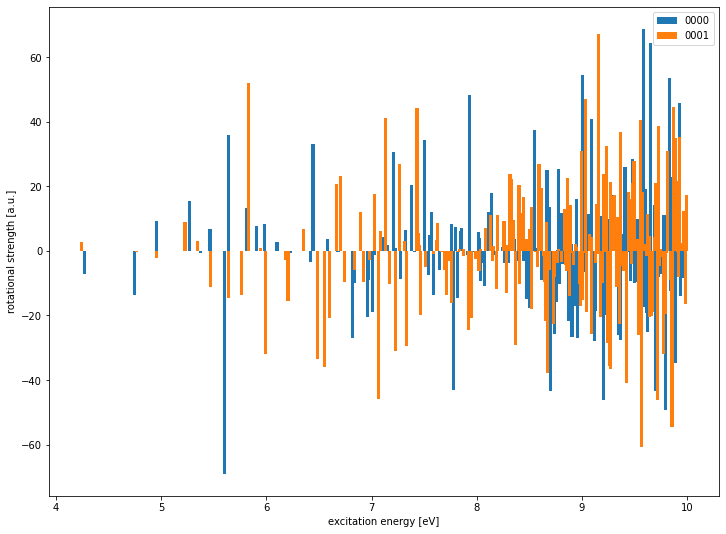

In [22]:
#solution
from __future__ import annotations

def read_in_exc_rot(file : str) -> Tuple[ np.array, np.array]:
    """
    Read in the excitation energies and rotational strengths from an stda output

    Args:
        file : string containing the file path
        
    Returns:
        en : excitation energies (in eV)
        rot : rotational strengths in the velocity formalism    
    """
    df = pd.read_csv(file, sep="\s+", skiprows=13, names=["ind", "exc", "osc_l", "osc_v", "rot_l", "rot_v"])
    en = df["exc"].to_numpy()
    rot = df["rot_v"].to_numpy()
    return en, rot

root = "../data/exercise_8/"

plt.figure(figsize=(12,9))
for conf in ["0000", "0001"]:
    exc, rot_v = read_in_exc_rot(root+conf+"/tda.dat")
    plt.bar(exc, rot_v, 0.03, label=conf)

plt.xlabel("excitation energy [eV]")
plt.ylabel("rotational strength [a.u.]")
plt.legend()
plt.show()

## Task 2 

Those so-called "sticks" that we have plotted in the previous task don't result in a continuous spectrum.  
The most common technique to broaden sticks to give spectra is called Gauss convolution, since Gauss functions are used to broaden the peak.  
The Gaussian functions have two parameters: $x_0$ the center of the distribution (here: the distribution energy), and the width of the Gaussian.  
Usually, the width is set by the user in a way that we determine the width of the Gaussian distribution at half maximum (FWHM).  
Therefore, we need to scale the FWHM value to get $\sigma$, the scaling is given by: $\sigma = \frac{\text{FWHM}}{2\sqrt{2\ln{2}}}$

$$
g(x, x_0) = \frac{1}{\sigma \sqrt{2\pi}} \exp{\left(-\frac{(x-x_0)^2}{2\sigma^2}\right)} \\
I(\epsilon) = \sum_{i}^{n_{\text{exc.}}} g(\epsilon, \epsilon_i, \text{FWHM}) \cdot R_i 
$$

The spectrum is computed by evaluating a Gaussian distribution on the interval of energies $\epsilon$ for every excitation. This values are then added up as shown by the second equation above.  
Write a function that computes the spectrum based on the following parameters: minimal energy of the interval, maximal energy of the interval, number of values in the interval, exc. energies of the sticks, rotational strengths, FWHM.  
Compute the spectrum for both conformers, for an interval $\epsilon$ [3.8 eV, 10.4 eV] and 1000 points, and a FWHM value of 0.2 eV.  
Plot the spectra together with the corresponding sticks in a figure.


In [23]:
# Write your solution here

<span style="color:red"> Solution: </span>

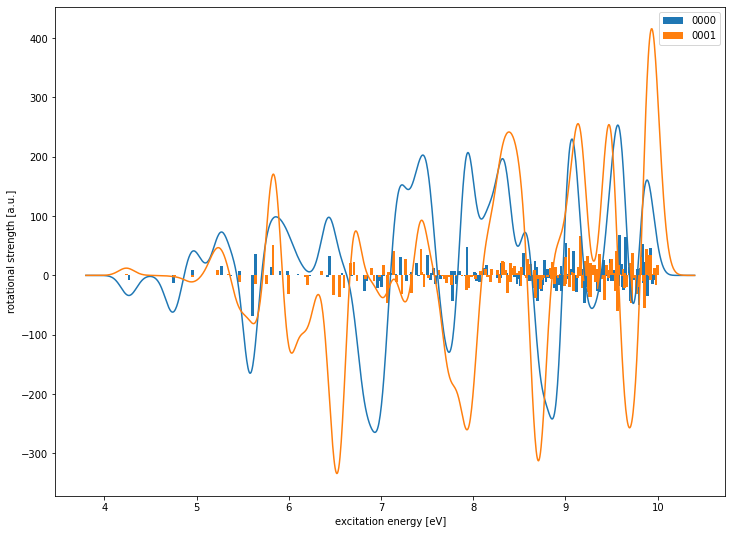

In [24]:
def gaussian(x_0 :  float, width : float, x : np.array) -> np.array:
    """
    Compute Gaussian distribution over an interval of values x, for a Gaussian centered at x_0 with a a given width
    
    Args:
        x_0 : center of the Gaussian distribution
        width : FWHM of the Gaussian
        x : values for which the distribution is computed
    """
    sigma = width  / (2*np.sqrt(2*np.log(2)))
    norm = sigma * np.sqrt(2*np.pi)
    return (1/norm) * np.exp(-0.5*((x_0 - x)/sigma)**2)

def compute_spectrum_eV(emin : float, emax : float, stick_pos: np.array , f_pos : np.array, width = 0.2, steps = 1000) -> Tuple[np.array, np.array]:
    """
    Compute the ECD spectrum for the interval [emin, emax] using Gaussian convolution of the excitation energies and corresponding oscillator strengths
    
    Args:
        emin : minimum exc. energy in eV
        emax : maximum exc. energy in eV
        stick_pos : exc. energies of the sticks
        f_pos : oscillator strength at the corresponding exc. energy
        width : FWHM value of the Gaussian in eV (default : 0.2 eV)
        steps : number of x values to compute for the spectrum (default : 100) 
    """
    x_values = np.linspace(emin, emax, steps)
    spectrum = np.zeros(steps)
    for i in range(stick_pos.size):
        spectrum += gaussian(stick_pos[i], width, x_values) * f_pos[i]
    return x_values, spectrum
        

plt.figure(figsize=(12,9))
for conf in ["0000", "0001"]:
    exc, rot_v = read_in_exc_rot(root+conf+"/tda.dat")
    x, y = compute_spectrum_eV(3.8, 10.4, exc, rot_v)
    plt.bar(exc, rot_v, 0.03, label=conf)
    plt.plot(x,y)

plt.xlabel("excitation energy [eV]")
plt.ylabel("rotational strength [a.u.]")
plt.legend()
plt.show() 


## Task 3

From the previous tasks, we have observed that for this molecule the ECD spectrum shows different signs depending on the conformer.  
This also shows that it is very important to do a conformer search when computing properties, without this information our simulation would not be able to describe the reality.  
The spectra of our conformers are scaled using Boltzmann weights based on their free Gibbs energies.  
We will be using the Boltzmann weights computed during the above mentioned project.  
The theory levels used for the individual contributions can be found in the supporting information of the paper.  
We provide them as a `boltzmann.csv` file, this file can be read in using `pandas.read_csv()` to get the Boltzmann weights.
Differences between the spectra in this exercise and the publication are due to an additional MD sampling used in the publication.

To compare with experiment usually the spectrum is shown in nm rather than eV.  
Write a function to convert eV to nm and one to convert from nm to eV. Use the `scipy.constants` module for the conversion! 
When plotting a spectrum it is important to execute the Gaussian convolution in the energy unit and then convert to wavelengths.  
Write a function to convert a spectrum in nm, the emin and emax parameters are given in nm, the width will remain at 0.2 eV.  
Remember that energy is proportional to the inverse of the wavelength, so `emin` will be 300 nm and `emax` 200 nm.  

To consider the Boltzmann weights, the oscillator strength is multiplied by the Boltzmann weight of the according species. 
Plot the spectrum of conformer `0000` and `0001` as well as the Boltzmann-weighted spectrum in one plot. 


In [25]:
# Write Your solution here


<span style="color:red"> Solution: </span>

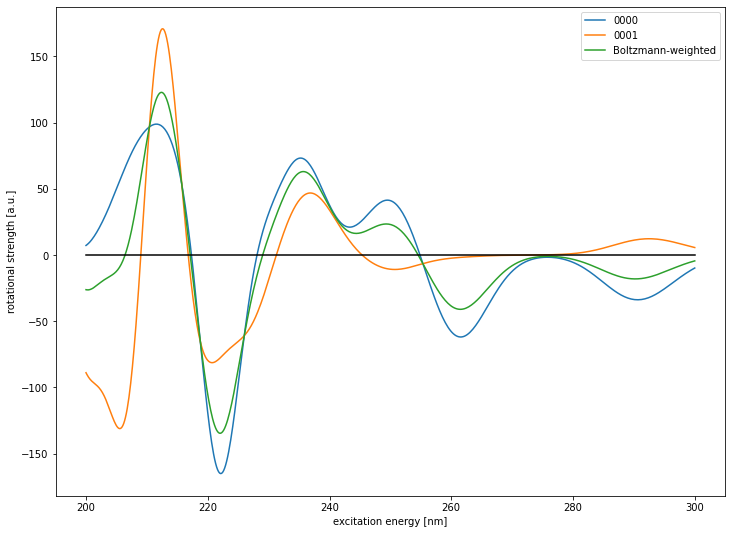

In [26]:
#Solution
def eV_to_nm(eV):
    """Convert an energy value from eV to nm"""
    h = sc.Planck
    eV_ = sc.electron_volt 
    c =sc.speed_of_light
    return ((h*c)/(eV*eV_)*10**9)

def nm_to_eV(nm):
    """Convert a wavelength from nm to eV"""
    h = sc.Planck
    eV_ = sc.electron_volt 
    c =sc.speed_of_light
    return ((h*c)/(nm*10**-9)*1/eV_)

def compute_spectrum_nm(emin, emax, stick_pos, f_pos, **kwargs):
    """
    Compute a spectrum in nm.
    """
    x, y = compute_spectrum_eV(nm_to_eV(emin), nm_to_eV(emax), stick_pos, f_pos, **kwargs)
    return eV_to_nm(x), y

def compute_ensemble_nm(list_files, weights, emin, emax, **kwargs):
    """
    Compute an ensemble averaged spectrum using weights for each species.
    """
    if "steps" in kwargs:
        step = kwargs.get("steps")
    else:
        step = 1000
    y = np.zeros(step)
    
    for i, file_ in enumerate(list_files):
        exc, rot_v = read_in_exc_rot(file_)
        rot_v *= weights[i]
        x_, y_ = compute_spectrum_nm(emin, emax, exc, rot_v, **kwargs)
        y += y_
    
    return x_, y


df = pd.read_csv(root+"boltzmann.csv")
plt.figure(figsize=(12,9))
steps = 500
list_files = [root+conf+"/tda.dat" for conf in ["0000","0001"]]

for conf in ["0000", "0001"]:
    exc, rot_v = read_in_exc_rot(root+conf+"/tda.dat")
    x, y = compute_spectrum_nm(300, 200, exc, rot_v, steps=steps)
    plt.plot(x,y,label=conf)
    
x, y_ = compute_ensemble_nm(list_files, list(df["weight"]), 300, 200, steps = steps)
plt.plot(x,y_, label = "Boltzmann-weighted")
plt.plot([200,300], [0,0], c = "k")
plt.xlabel("excitation energy [nm]")
plt.ylabel("rotational strength [a.u.]")
plt.legend()
plt.show() 

## Additional Task

Show that a Gaussian convolution in the wavelength domain, gives another spectrum than the right conversion in the energy domain.  
Take 10 nm for the FWHM argument and scale the spectrum given by 50. PLot the ECD spectrum between [150nm, 300nm]

Discuss where the differences are coming from.

<span style="color:red"> Solution: </span>

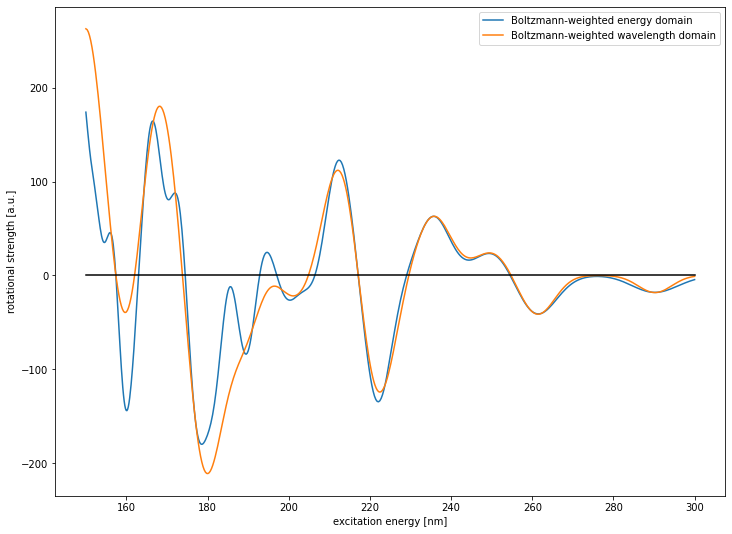

In [29]:
def compute_spectrum_nm_wrong(emin, emax, stick_pos, f_pos, **kwargs):
    """
    Compute a spectrum in nm.
    """
    x, y = compute_spectrum_eV(emin, emax, eV_to_nm(stick_pos), f_pos, **kwargs)
    return x, y

def compute_ensemble_nm_wrong(list_files, weights, emin, emax, **kwargs):
    """
    Compute an ensemble averaged spectrum using weights for each species.
    """
    if "steps" in kwargs:
        step = kwargs.get("steps")
    else:
        step = 1000
    y = np.zeros(step)
    
    for i, file_ in enumerate(list_files):
        exc, rot_v = read_in_exc_rot(file_)
        rot_v *= weights[i]
        x_, y_ = compute_spectrum_nm_wrong(emin, emax, exc, rot_v, **kwargs)
        y += y_
    
    return x_, y

df = pd.read_csv(root+"boltzmann.csv")
plt.figure(figsize=(12,9))
steps = 500
list_files = [root+conf+"/tda.dat" for conf in ["0000","0001"]]
    
x, y_ = compute_ensemble_nm(list_files, list(df["weight"]), 300, 150, steps = steps)
plt.plot(x,y_, label = "Boltzmann-weighted energy domain")

x, y_ = compute_ensemble_nm_wrong(list_files, list(df["weight"]), 300, 150, steps = steps, width=10)
plt.plot(x,y_*50, label = "Boltzmann-weighted wavelength domain")

plt.plot([150,300], [0,0], c = "k")
plt.xlabel("excitation energy [nm]")
plt.ylabel("rotational strength [a.u.]")
plt.legend()
plt.show() 